In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
fasta_content="D:\SEMESTER 8\Semester Project\Cpg_Dataset_Sequences.fa"

# Preprocessing: Extracting and encoding sequences
def parse_fasta(content):
    sequences = []
    labels=[]
    with open(content,'r') as file:
        for line in file:
            if line.startswith("#"):
                # label=line[-3:]
                label=line[-2:]
                labels.append(label.strip())
            else:
                sequences.append(line.strip())
    
    return sequences,labels

# Padding sequences to the same length
def pad_sequences_simple(sequences, maxlen, padding_value=0):
    return [seq + [padding_value] * (maxlen - len(seq)) for seq in sequences]

# Extract sequences from the file
sequences,labels = parse_fasta(fasta_content)

# Encoding sequences into numerical format (A=1, T=2, C=3, G=4)
char_to_int = {'A': 1, 'T': 2, 'C': 3, 'G': 4}
encoded_sequences = [[char_to_int.get(char, 0) for char in seq] for seq in sequences]
num_classes = len(char_to_int) + 1  # Include padding index
embedding_dim = 20  # Example embedding dimension
max_length = 100
padding_value = 0  # Use 0 as the padding index
padded_sequences = pad_sequences_simple(encoded_sequences, max_length, padding_value=padding_value)


In [5]:
# Preprocessing: Add a mapping for labels
# label_to_int = {'0A':1,'0T': 2,'0G': 3,'0C': 4, '1A': 5,'1T': 6,'1G': 7,'1C': 8}  # Example mapping; update based on your labels
label_to_int={'0':0,'1':1}
numerical_labels = [label_to_int[label] for label in labels]  # Convert labels to numerical format

# Create a TensorDataset with both sequences and labels
padded_sequences_tensor = torch.tensor(padded_sequences, dtype=torch.float32)
numerical_labels_tensor = torch.tensor(numerical_labels, dtype=torch.long)

# Normalize sequences to [0, 1]
max_value = padded_sequences_tensor.max()
padded_sequences_tensor = padded_sequences_tensor / max_value  # Scale values between 0 and 1

# Combine sequences and labels into a TensorDataset
dataset = torch.utils.data.TensorDataset(padded_sequences_tensor, numerical_labels_tensor)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Modify the Autoencoder to return both encoded and decoded representations
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2)   # Output 2 dimensions for latent space visualization
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,100),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded  # Return both encoded and decoded outputs

# Reinitialize the model for latent space visualization
input_dim = padded_sequences_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for batch, _ in dataloader:  # Ignore labels during training
        optimizer.zero_grad()
        _, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')

# Visualization: Extract latent points
model.eval()
latent_points = []
labels_list = []

with torch.no_grad():
    for batch, labels in dataloader:
        encoded, _ = model(batch)  # Extract encoded (latent) representations
        latent_points.append(encoded.numpy())  # Convert latent points to NumPy
        labels_list.append(labels.numpy())  # Convert labels to NumPy

# Combine latent points and labels for plotting
latent_points = np.concatenate(latent_points, axis=0)
labels_list = np.concatenate(labels_list, axis=0)


Epoch: 1, Loss: 0.0504
Epoch: 2, Loss: 0.0488
Epoch: 3, Loss: 0.0505
Epoch: 4, Loss: 0.0460
Epoch: 5, Loss: 0.0482
Epoch: 6, Loss: 0.0541
Epoch: 7, Loss: 0.0533
Epoch: 8, Loss: 0.0497
Epoch: 9, Loss: 0.0524
Epoch: 10, Loss: 0.0513


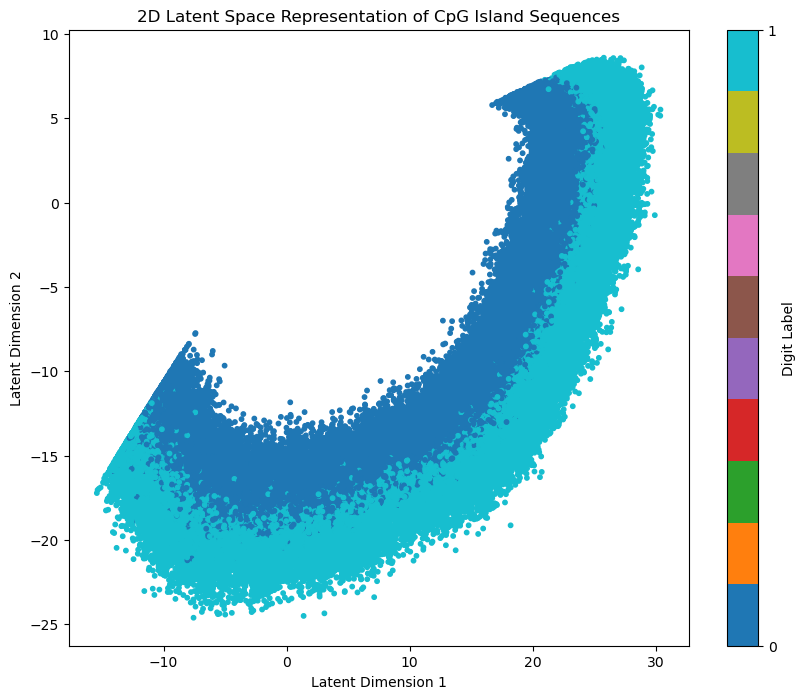

In [6]:
# Plot latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels_list, cmap="tab10", s=10)
plt.colorbar(scatter, ticks=range(10), label="Digit Label")
plt.title("2D Latent Space Representation of CpG Island Sequences")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()